In [11]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


## Data Preprocessing

In [12]:
# Hyperparameters

# y column normalize scaler
normalizer_constant = 2

# time series step size
time_step = 45

# NN parameters
learning_rate = 0.1
num_epoch = 500
NN_layer_dimension = [100,100]
train_size = 568 # 80% of the data

In [13]:
# SNP = pd.read_csv('./SP500.csv')
SNP = pd.read_csv('./SPX_500_Data.csv')

# get all attributes
SNP_attributes = SNP.iloc[:,1:7]
# get last column (y)
# SNP_price = SNP.iloc[:,4:]
SNP_price = SNP['Close']
SNP_price = np.array(SNP_price)
SNP_price = np.reshape(SNP_price, (-1,1))

# normalize the data using MinMax scaller
scaler = MinMaxScaler()
scaler.fit(SNP_attributes)
SNP_attributes = scaler.transform(SNP_attributes)

Price_scaler = MinMaxScaler()
Price_scaler.fit(SNP_price)
SNP_price = Price_scaler.transform(SNP_price)


# scale data to [0,1]
# SNP_price = (SNP_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())

train_data = SNP_price[0:train_size, :]
train_data_mul = SNP_attributes[:, :]
# train_data_mul = np.array(train_data_mul)

# univariate
def create_train_data(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i,0])
        y.append(data[i,0])
    return x, y

# multivariate
def create_train_data_mul(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0:data.shape[1]])
        y.append(data[i:i+1,0])
    return x, y

X_train, y_train = create_train_data_mul(train_data_mul)


In [14]:
# Reshaping 
X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [15]:
# NN 
def create_model(units=[12,3], learning_rate=0.3):
    model = tf.keras.models.Sequential()
    # LSTM RNN model
    model.add(LSTM(units=64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1))

    # opt = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
    model.compile(optimizer='adam',loss='mean_squared_error')

    return model

model = create_model(units=NN_layer_dimension, learning_rate=learning_rate)

In [16]:
# Train
model.fit(X_train, y_train, epochs=num_epoch, batch_size=36, verbose=2)

Epoch 1/500
417/417 - 10s - loss: 0.0012 - 10s/epoch - 25ms/step
Epoch 2/500
417/417 - 9s - loss: 3.5133e-04 - 9s/epoch - 21ms/step
Epoch 3/500
417/417 - 9s - loss: 3.4654e-04 - 9s/epoch - 21ms/step
Epoch 4/500
417/417 - 9s - loss: 2.8298e-04 - 9s/epoch - 21ms/step
Epoch 5/500
417/417 - 8s - loss: 2.8211e-04 - 8s/epoch - 20ms/step
Epoch 6/500
417/417 - 9s - loss: 3.0218e-04 - 9s/epoch - 21ms/step
Epoch 7/500
417/417 - 9s - loss: 3.0285e-04 - 9s/epoch - 21ms/step
Epoch 8/500
417/417 - 8s - loss: 3.7768e-04 - 8s/epoch - 20ms/step
Epoch 9/500
417/417 - 8s - loss: 2.7712e-04 - 8s/epoch - 20ms/step
Epoch 10/500
417/417 - 8s - loss: 3.0319e-04 - 8s/epoch - 20ms/step
Epoch 11/500
417/417 - 8s - loss: 2.7040e-04 - 8s/epoch - 20ms/step
Epoch 12/500
417/417 - 8s - loss: 2.7518e-04 - 8s/epoch - 20ms/step
Epoch 13/500
417/417 - 8s - loss: 2.8172e-04 - 8s/epoch - 20ms/step
Epoch 14/500
417/417 - 9s - loss: 2.7096e-04 - 9s/epoch - 20ms/step
Epoch 15/500
417/417 - 9s - loss: 2.7039e-04 - 9s/epoch - 2

In [17]:
model.save('./NN_model')

INFO:tensorflow:Assets written to: ./NN_model\assets


INFO:tensorflow:Assets written to: ./NN_model\assets


In [18]:
# test data 
test_data = SNP_price[train_size - time_step:, :]
test_data_mul = SNP_attributes[train_size - time_step:, :]
test_data_mul_full = SNP_attributes[:, :]
# test_data_mul = np.array(test_data_mul)
X_test = []
X_test_mul = []
X_test_mul_full = []
y_test = SNP_price[train_size:, :]

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i,0])

for i in range(time_step, len(test_data_mul)):
    X_test_mul.append(test_data_mul[i-time_step:i,0:test_data_mul.shape[1]])

for i in range(time_step, len(test_data_mul_full)):
    X_test_mul_full.append(test_data_mul_full[i-time_step:i,0:test_data_mul_full.shape[1]])


X_test, X_test_mul, X_test_mul_full = np.array(X_test), np.array(X_test_mul), np.array(X_test_mul_full)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test_mul = np.reshape(X_test_mul, (X_test_mul.shape[0], X_test_mul.shape[1], X_test_mul.shape[2]))
X_test_mul_full = np.reshape(X_test_mul_full, (X_test_mul_full.shape[0], X_test_mul_full.shape[1], X_test_mul_full.shape[2]))

In [19]:
# predicted_price = model.predict(X_test)
predicted_price_mul = model.predict(X_test_mul)
# predicted_price = Price_scaler.inverse_transform(predicted_price)
predicted_price_mul = np.repeat(predicted_price_mul,X_test_mul.shape[2],axis=-1)
predicted_price_mul = scaler.inverse_transform(predicted_price_mul)[:,0]

predict_full = model.predict(X_test_mul_full)
predict_full = np.repeat(predict_full,X_test_mul_full.shape[2], axis=-1)
predict_full = scaler.inverse_transform(predict_full)[:,0]

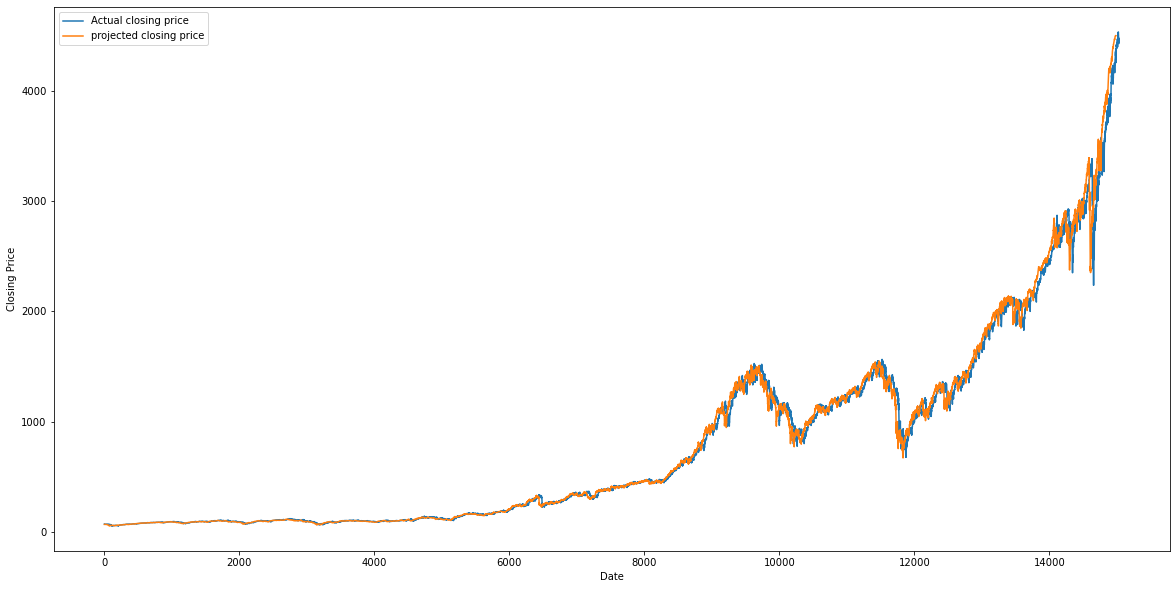

In [20]:
plt.figure(figsize=(20,10))
training = SNP[:]
# valid = SNP[train_size:]
# valid['pred'] = predicted_price_mul
projection = predict_full

#plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(training["Close"], label = 'Actual closing price')
# plt.plot(valid[['Closing Price', 'pred']])
plt.plot(projection, label = 'projected closing price')
plt.legend()
plt.show()
